In [1]:
%matplotlib inline

In [2]:
from pycisTopic.qc import *

/media/data/users/fderop/software/miniconda/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


In [3]:
samplepath = ""
qcpath = "pycistopic_consensus/"

In [4]:
# Load metadata
import pickle

infile = open(qcpath + "metadata_bc.pkl", "rb")
metadata_bc_dict = pickle.load(infile)
infile.close()

In [5]:
# Load profile data
infile = open(qcpath + "profile_data_dict.pkl", "rb")
profile_data_dict = pickle.load(infile)
infile.close()

In [6]:
import pickle

infile = open(qcpath + "bc_passing_filters.pkl", "rb")
bc_passing_filter = pickle.load(infile)
infile.close()

In [7]:
dictkeys = list(metadata_bc_dict.keys())

In [8]:
test = metadata_bc_dict[dictkeys[0]]["Unique_nr_frag"] >= 10

In [9]:
test.value_counts()

True    376898
Name: Unique_nr_frag, dtype: int64

In [10]:
for key in profile_data_dict.keys():
    brp = profile_data_dict[key]["barcode_rank_plot"]
    brp.index += "_" + key

merge them and calculate sizes (we need sizes to normalize the tss and fragment sizes plots)

In [30]:
profile_data_dict_selected = {}
brp_merged = pd.DataFrame()
dup_merged = pd.DataFrame()
ins_merged = {}
tss_merged = {}
tssbc_merged = pd.DataFrame()
frip_merged = pd.DataFrame()
for key in profile_data_dict.keys():
    brp = profile_data_dict[key]["barcode_rank_plot"]
    brp.index += "_" + key
    brp_merged = pd.concat([brp_merged, brp])

    dup = profile_data_dict[key]["duplicate_rate"]
    dup.index += "_" + key
    dup_merged = pd.concat([dup_merged, dup])

    ins = profile_data_dict[key]["insert_size_distribution"]
    ins_merged[key] = ins

    tss = profile_data_dict[key]["profile_tss"]
    tss_merged[key] = tss

    tssbc = profile_data_dict[key]["profile_tssPerBarcode"]
    tssbc.index += "_" + key
    tssbc_merged = pd.concat([tssbc_merged, tssbc])

    frip = profile_data_dict[key]["frip"]
    frip.index += "_" + key
    frip_merged = pd.concat([frip_merged, frip])
    profile_data_dict_selected[key] = {
        "barcode_rank_plot": brp,
        "duplicate_rate": dup,
        "insert_size_distribution": ins,
        "profile_tss": tss,
        "profile_tssPerBarcode": tssbc,
        "frip": frip,
    }

brp_merged = brp_merged.sort_values(by="Unique_nr_frag", ascending=False)
brp_merged["Barcode_rank"] = range(0, len(brp_merged))

# Now we need to make a concatenated insert size and tss normalised to total unique fragment count (for unfiltered matrix):

In [31]:
import pandas as pd
# concatenate the insert sizes per barcode
ins_concatenated = pd.DataFrame()
for key in ins_merged.keys():
    df_fixed = ins_merged[key].set_index(ins_merged[key]["Width"])
    ins_concatenated = ins_concatenated.add(df_fixed, fill_value=0)
ins_concatenated["Nr_frag"].sum()
ins_concatenated["Ratio_frag"] = (
    ins_concatenated["Nr_frag"] / ins_concatenated["Nr_frag"].sum()
)
ins_concatenated["Width"] = ins_concatenated.index

# make a list of all total unique fragments
sizes = pd.DataFrame(data=None, index=metadata_bc_dict.keys())
sizes["ufrags"] = 0
metadata_merged = pd.DataFrame()
for key in metadata_bc_dict.keys():
    print(metadata_bc_dict[key]["Unique_nr_frag"].sum())
    sizes["ufrags"].loc[key] = metadata_bc_dict[key]["Unique_nr_frag"].sum()
    metadata = metadata_bc_dict[key]
    metadata.index += "_" + key
    metadata_merged = pd.concat([metadata_merged, metadata])

weight = sizes / sizes.sum()

tss_concatenated = pd.DataFrame()
for key in tss_merged.keys():
    df_fixed = tss_merged[key]
    df_fixed["TSS_enrichment"] = df_fixed["TSS_enrichment"] * weight.loc[key]["ufrags"]
    tss_concatenated = tss_concatenated.add(df_fixed, fill_value=0)


# use that list to normalise tss enrichment to the total
# reset position
tss_concatenated["Position"] = tss_merged[key]["Position"]

32945288
2509800
31322912
2622669
33982506
32904799
38724583


# Run this instead if you want to select BCs passing filter (don't run if you don't want to select BCs passing filter)

In [ ]:
profile_data_dict_selected = {}
brp_merged = pd.DataFrame()
dup_merged = pd.DataFrame()
ins_merged = {}
tss_merged = {}
tssbc_merged = pd.DataFrame()
frip_merged = pd.DataFrame()
for key in profile_data_dict.keys():
    brp = profile_data_dict[key]["barcode_rank_plot"][
        profile_data_dict[key]["barcode_rank_plot"].index.isin(bc_passing_filter[key])
    ]
    brp.index += "_" + key
    brp_merged = pd.concat([brp_merged, brp])

    dup = profile_data_dict[key]["duplicate_rate"][
        profile_data_dict[key]["duplicate_rate"].index.isin(bc_passing_filter[key])
    ]
    dup.index += "_" + key
    dup_merged = pd.concat([dup_merged, dup])

    ins = profile_data_dict[key]["insert_size_distribution"]
    ins_merged[key] = ins

    tss = profile_data_dict[key]["profile_tss"]
    tss_merged[key] = tss

    tssbc = profile_data_dict[key]["profile_tssPerBarcode"][
        profile_data_dict[key]["profile_tssPerBarcode"].index.isin(
            bc_passing_filter[key]
        )
    ]
    tssbc.index += "_" + key
    tssbc_merged = pd.concat([tssbc_merged, tssbc])

    frip = profile_data_dict[key]["frip"][
        profile_data_dict[key]["frip"].index.isin(bc_passing_filter[key])
    ]
    frip.index += "_" + key
    frip_merged = pd.concat([frip_merged, frip])
    profile_data_dict_selected[key] = {
        "barcode_rank_plot": brp,
        "duplicate_rate": dup,
        "insert_size_distribution": ins,
        "profile_tss": tss,
        "profile_tssPerBarcode": tssbc,
        "frip": frip,
    }

brp_merged = brp_merged.sort_values(by="Unique_nr_frag", ascending=False)
brp_merged["Barcode_rank"] = range(0, len(brp_merged))

In [ ]:
# concatenate the insert sizes per barcode
ins_concatenated = pd.DataFrame()
for key in ins_merged.keys():
    df_fixed = ins_merged[key].set_index(ins_merged[key]["Width"])
    ins_concatenated = ins_concatenated.add(df_fixed, fill_value=0)
ins_concatenated["Nr_frag"].sum()
ins_concatenated["Ratio_frag"] = (
    ins_concatenated["Nr_frag"] / ins_concatenated["Nr_frag"].sum()
)
ins_concatenated["Width"] = ins_concatenated.index

# make a list of all total unique fragments
sizes = pd.DataFrame(data=None, index=metadata_bc_dict.keys())
sizes["ufrags"] = 0
metadata_merged = pd.DataFrame()
for key in metadata_bc_dict.keys():
    print(metadata_bc_dict[key]["Unique_nr_frag"].sum())
    sizes["ufrags"].loc[key] = metadata_bc_dict[key]["Unique_nr_frag"].sum()
    metadata = metadata_bc_dict[key][
        metadata_bc_dict[key].index.isin(bc_passing_filter[key])
    ]
    metadata.index += "_" + key
    metadata_merged = pd.concat([metadata_merged, metadata])

weight = sizes / sizes.sum()

tss_concatenated = pd.DataFrame()
for key in tss_merged.keys():
    df_fixed = tss_merged[key]
    df_fixed["TSS_enrichment"] = df_fixed["TSS_enrichment"] * weight.loc[key]["ufrags"]
    tss_concatenated = tss_concatenated.add(df_fixed, fill_value=0)


# use that list to normalise tss enrichment to the total
# reset position
tss_concatenated["Position"] = tss_merged[key]["Position"]

## Merge profile data

In [32]:
profile_data_dict_selected_merged = {}

In [33]:
profile_data_dict_selected_merged["merged"] = {
    "barcode_rank_plot": brp_merged,
    "duplicate_rate": dup_merged,
    "insert_size_distribution": ins_concatenated,
    "profile_tss": tss_concatenated,
    "profile_tssPerBarcode": tssbc_merged,
    "frip": frip_merged,
}

In [34]:
def save_object(obj, filename):
    with open(filename, "wb") as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


# sample usage
# save_object(company1, 'company1.pkl')

In [35]:
save_object(
    profile_data_dict_selected_merged,
    "qc_stats/profile_data_dict_selected_merged_allbc.pkl",
)

# Plot profile data

In [4]:
import pickle

with open("qc_stats/profile_data_dict_selected_merged_allbc.pkl", "rb") as f:
    profile_data_dict_selected_merged = pickle.load(f)

In [ ]:
qcpath = "pycistopic_consensus/"
plot_sample_metrics(
    profile_data_dict_selected,
    profile_list=[
        "barcode_rank_plot",
        "insert_size_distribution",
        "profile_tss",
        "frip",
    ],
    insert_size_distriubtion_xlim=[0, 600],
    # legend_outside=True,
    ncol=4,
    cmap="Paired",
    plot=True,
    save=qcpath + "sample_metrics_selectedcells_separate.pdf",
)

In [ ]:
qcpath = "pycistopic_consensus/"
plot_sample_metrics(
    profile_data_dict_selected_merged,
    insert_size_distriubtion_xlim=[0, 600],
    # legend_outside=True,
    remove_duplicates=True,
    ncol=2,
    cmap="viridis",
    plot=True,
    save=qcpath + "sample_metrics_selectedcells_merged_nosel.pdf",
)

/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


# Fragment level statistics

In [5]:
import seaborn as sns
from scipy.stats import gaussian_kde

In [6]:
context = "talk"
style = "darkgrid"

In [22]:
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})
sns.set_context(context)
color = sns.color_palette("Blues")[5]
linewidth = 3

sample = "merged"
category = "insert_size_distribution"
xvar = "Width"
yvar = "Ratio_frag"
x = profile_data_dict_selected_merged[sample][category][xvar]
y = profile_data_dict_selected_merged[sample][category][yvar] * 100

sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})
sns.set_context(context)
color = sns.color_palette("Blues")[5]

ax = sns.lineplot(
    data=profile_data_dict_selected_merged[sample][category],
    x=x,
    y=y,
    palette="viridis",
    linewidth=linewidth,
)
ax.set(xscale="linear")
ax.set(yscale="linear")
ax.set(xlim=[0, 600])
ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())

ax.set_xlabel("Fragment length")
ax.set_ylabel("Fraction (%)")

plt.tight_layout()
plt.savefig("plts_pub/fragment_length.svg", dpi=300)
plt.savefig("plts_pub/fragment_length.png", dpi=300)
plt.close()

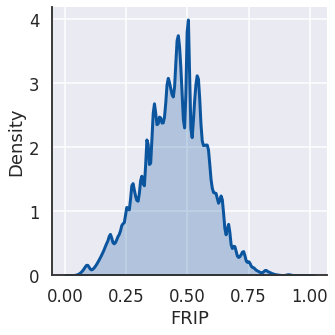

In [63]:
sns.set_context(context)
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})

color = sns.color_palette("Blues")[5]

sample = "merged"
category = "frip"
xvar = "FRIP"
x = profile_data_dict_selected_merged[sample][category][xvar]

sns.displot(
    data=profile_data_dict_selected_merged[sample][category],
    x=xvar,
    color=color,
    kind="kde",
    fill=True,
    linewidth=linewidth,
)
ax.set(xscale="linear")
ax.set(yscale="linear")
ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())

fig = plt.gcf()
fig.savefig("plts_pub/frip.svg", dpi=300)
fig.savefig("plts_pub/frip.png", dpi=300)
plt.show()
plt.close()

# Cell level statistics

In [ ]:
import pandas as pd

metadata_bc_dict_selected = {}
metadata_bc_dict_selected = pd.DataFrame()
for key in metadata_bc_dict.keys():
    metadata = metadata_bc_dict[key][
        metadata_bc_dict[key].index.isin(bc_passing_filter[key])
    ]
    metadata.index += "_" + key
    metadata_bc_dict_selected = pd.concat([metadata_bc_dict_selected, metadata])

In [ ]:
metadata_bc_dict_selected

In [ ]:
sample = "merged"
x = metadata_bc_dict_selected
print(x.median())
print(x.mean())

I have to scale all of the densities to the same axis

In [8]:
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np

In [13]:
markersize = 5
style = "darkgrid"
context = "talk"

sample = "merged"
category = "frip"

In [14]:
profile_data_dict_selected_merged[sample][category]["duprate"] = (
    1
    - profile_data_dict_selected_merged[sample][category]["Unique_nr_frag"]
    / profile_data_dict_selected_merged[sample][category]["Total_nr_frag"]
)

In [16]:
sns.set_context(context)
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})


xvar = "Unique_nr_frag"
yvar = "duprate"

x = profile_data_dict_selected_merged[sample][category][xvar]
y = profile_data_dict_selected_merged[sample][category][yvar]

xy = np.vstack([np.log10(x), y])
# Create definition.
def calc_kernel(xy):
    return gaussian_kde(xy)(xy)


# Choose number of cores and split input array.
cores = 32
torun = np.array_split(xy, cores, axis=1)

# Calculate
pool = Pool(processes=cores)
results = pool.map(calc_kernel, torun)
z = np.concatenate(results)
# Reintegrate and calculate results
# multiprocessing filter/sample:  0.496874094009

# bins = np.linspace(z.min(), z.max(), 10)
# digitized = np.digitize(z, bins)
# bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
# digitized_rescaled = np.interp(digitized, (digitized.min(), digitized.max()), (z.min(), z.max()))

ax = sns.scatterplot(
    data=profile_data_dict_selected_merged[sample][category],
    x=xvar,
    y=yvar,
    hue=z,
    palette="viridis",
    edgecolor=None,
    s=markersize,
)
ax.set(xscale="log")
ax.set(yscale="linear")
ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())

ax.set_xlabel("Unique fragments")
ax.set_ylabel("Saturation")
plt.axvline(x=1000, color="red")
plt.tight_layout()
ax.get_legend().remove()

# plt.axhline(y = 5, color ='red')


fig = plt.gcf()
# fig.savefig(
#     "plts_pub/ufrag_duprate_markersize" + str(markersize) + "_nosel.svg", dpi=600
# )
fig.savefig(
    "plts_pub/ufrag_duprate_markersize" + str(markersize) + "_nosel.png", dpi=600, transparent=True
)
fig.savefig(
    "plts_pub/ufrag_duprate_markersize" + str(markersize) + "_nosel.tiff", dpi=600, transparent=True
)
print(z.min())
print(z.max())
pool.close()
pool.join()

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


0.002124989422043063
6.562199307202299


# frip 

In [17]:
sample = "merged"
category = "frip"
xvar = "Unique_nr_frag"
yvar = "FRIP"
profile_data_dict_selected_merged[sample][category]["FRIP"]

AACATTCAGGAAGAACGGTGAACGCCTGCT_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2    0.304348
AACATTCAGGAAGAACGGTGAAGTGTAGAA_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2    0.384615
AACATTCAGGAAGAACGGTGACAACAGGAA_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2    0.583333
AACATTCAGGAAGAACGGTGACACACTAGG_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2    0.574468
AACATTCAGGAAGAACGGTGACCAATATCG_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2_HYA__combined__20210323_cortex_phu_dv_etssb_1-2_S2    0.461538
                                                                                                                                          ...   
TTGTCCGCCATTGGTCTCGTTTCATGAGGT_HYA__combined__20210323_cortex_phu_dv_etssb_1-3_S3_HYA__combined__20210323_cortex_phu_dv_etssb_1-3_

In [18]:
profile_data_dict_selected_merged[sample][category]["FRIP"].isnull().value_counts()

False    2146195
True        1444
Name: FRIP, dtype: int64

In [19]:
profile_data_dict_selected_merged[sample][category]["FRIP"].fillna(0, inplace=True)

In [20]:
profile_data_dict_selected_merged[sample][category]["FRIP"].isnull().value_counts()

False    2147639
Name: FRIP, dtype: int64

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


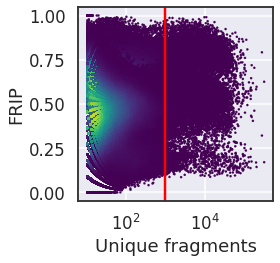

0.001085907567529688
4.922594727931435


In [21]:
sns.set_context(context)
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})

sample = "merged"
category = "frip"
xvar = "Unique_nr_frag"
yvar = "FRIP"
x = profile_data_dict_selected_merged[sample][category][xvar]
y = profile_data_dict_selected_merged[sample][category][yvar]

xy = np.vstack([np.log10(x), y])
# Create definition.
def calc_kernel(xy):
    return gaussian_kde(xy)(xy)


# Choose number of cores and split input array.
cores = 16
torun = np.array_split(xy, cores, axis=1)

# Calculate
pool = Pool(processes=cores)
results = pool.map(calc_kernel, torun)
z = np.concatenate(results)
# Reintegrate and calculate results
# multiprocessing filter/sample:  0.496874094009

# bins = np.linspace(z.min(), z.max(), 10)
# digitized = np.digitize(z, bins)
# bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
# digitized_rescaled = np.interp(
#     digitized, (digitized.min(), digitized.max()), (z.min(), z.max())
# )

ax = sns.scatterplot(
    data=profile_data_dict_selected_merged[sample][category],
    x=xvar,
    y=yvar,
    hue=z,
    palette="viridis",
    edgecolor=None,
    s=markersize,
)
ax.set(xscale="log")
ax.set(yscale="linear")

ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())

import matplotlib.ticker as mtick

ax.set_xlabel("Unique fragments")
ax.set_ylabel("FRIP")
plt.axvline(x=1000, color="red")
# plt.axhline(x=5, color="red")
ax.get_legend().remove()
plt.tight_layout()

fig = plt.gcf()
# fig.savefig("plts_pub/ufrag_frip_markersize" + str(markersize) + "_nosel.svg", dpi=100)
fig.savefig("plts_pub/ufrag_frip_markersize" + str(markersize) + "_nosel.png", dpi=600, transparent=True)
fig.savefig("plts_pub/ufrag_frip_markersize" + str(markersize) + "_nosel.tiff", dpi=600, transparent=True)


plt.show()
pool.close()
pool.join()
print(z.min())
print(z.max())

# 

In [ ]:
sns.set_context(context)
sns.set_style(style, {"axes.linewidth": 1, "axes.edgecolor": ".20"})

xvar = "Unique_nr_frag"
yvar = "TSS_enrichment"
x = metadata_merged[xvar]
y = metadata_merged[yvar]

xy = np.vstack([np.log10(x), y])
# Create definition.
def calc_kernel(xy):
    return gaussian_kde(xy)(xy)


# Choose number of cores and split input array.
cores = 32
torun = np.array_split(xy, cores, axis=1)

# Calculate
pool = Pool(processes=cores)
results = pool.map(calc_kernel, torun)
z = np.concatenate(results)
# Reintegrate and calculate results
# multiprocessing filter/sample:  0.496874094009

# bins = np.linspace(z.min(), z.max(), 10)
# digitized = np.digitize(z, bins)
# bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
# digitized_rescaled = np.interp(
#     digitized, (digitized.min(), digitized.max()), (z.min(), z.max())
# )

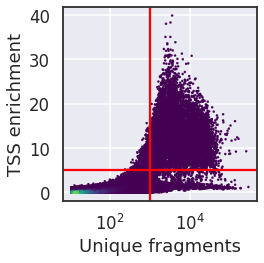

0.0002523193087529107
4.641650290671348


In [35]:
ax = sns.scatterplot(
    data=metadata_merged,
    x=xvar,
    y=yvar,
    hue=z,
    palette="viridis",
    edgecolor=None,
    s=markersize,
)
ax.set(xscale="log")
ax.set(yscale="linear")

ax.set_aspect("equal", adjustable="box")
ax.set_aspect(1.0 / ax.get_data_ratio())

import matplotlib.ticker as mtick

ax.set_xlabel("Unique fragments")
ax.set_ylabel("TSS enrichment")
plt.axvline(x=1000, color="red")
plt.axhline(y=5, color="red")
ax.get_legend().remove()
plt.tight_layout()

fig = plt.gcf()
# fig.savefig("plts_pub/ufrag_tss_markersize" + str(markersize) + "_nosel.svg", dpi=300)
fig.savefig("plts_pub/ufrag_tss_markersize" + str(markersize) + "_nosel.png", dpi=600, transparent=True)
fig.savefig("plts_pub/ufrag_tss_markersize" + str(markersize) + "_nosel.tiff", dpi=600, transparent=True)

pool.close()
pool.join()

plt.show()

print(z.min())
print(z.max())

# TSS enrichment plot for all samples

In [1]:
import sys
sys.version_info 

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

I like to use this little trick: since many of the cistopic commands take a long time (>1 hour), I let the notebook play a sound after they're finished.

In [2]:
from IPython.display import Audio
sound_file = '/staging/leuven/stg_00002/lcb/fderop/data/00000000_scripts/beep_silent.wav'
Audio(sound_file, autoplay=True)

In [31]:
import pycisTopic
pycisTopic.__version__

'0.1.dev214+gc72ef83.d20210522'

In [4]:
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [6]:
import pybiomart as pbm
import pandas as pd
import pickle

from pycisTopic.cistopic_class import *
from pycisTopic.qc import *
from pycisTopic.lda_models import *
from pycisTopic.clust_vis import *
from pycisTopic.topic_qc import *
from pycisTopic.diff_features import *
from pycisTopic.pseudobulk_peak_calling import *
from pycisTopic.iterative_peak_calling import *
from pycisTopic.topic_binarization import *

import glob

change the working directory to where you stored your `fragments/` directory.

In [7]:
import os
wdir = '/staging/leuven/stg_00002/lcb/fderop/data/20210407_20210323_reseq/'
os.chdir(wdir)

cistopic_out is where the cistopic output will go.

In [8]:
cistopic_out = 'pycistopic_consensus/'

# Get genome annotations from biomart
This information is necessary for cisTopic to calculate e.g. TSS enrichment. We are analysing mm10 mapped data here, so we pick the mm10 option. The biomart output is reshaped a little to fit cisTopic's needs.

In [9]:
# For mm10:
dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://nov2020.archive.ensembl.org/')
# For human:
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
# dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://grch37.ensembl.org/')


# For fly
#dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')

annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']

In [10]:
annot

,Chromosome,Start,Strand,Gene,Transcript_type
58,chr2,154551776,1,Actl10,protein_coding
624,chrX,31117674,1,Btbd35f29,protein_coding
946,chr7,84915781,1,Olfr290,protein_coding
977,chrY,90839177,-1,Gm21748,protein_coding
1000,chr4,108719649,1,3110021N24Rik,protein_coding
...,...,...,...,...,...
136372,chr6,134791334,-1,Dusp16,protein_coding
136373,chr14,51203391,1,Ear14,protein_coding
136374,chr14,51203689,1,Ear14,protein_coding
136378,chr12,85274286,1,Zc2hc1c,protein_coding


# Calculate cell metadata
Cistopic is going to calculate a number of statistics, e.g. number of total unique fragments, number of reads in peaks, TSS enrichment, ... on which we will later base our cell filtering. We make two dictionaries, one with a fragments file for each sample, and one with a regions file for each sample.

In [11]:
filenames = glob.glob('fragments/HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED.sinto.fragments.NONEGS.tsv.gz')
samples = [item.replace(".sinto.fragments.NONEGS.tsv.gz", "") for item in filenames]
samples = [item.replace("fragments/", "") for item in samples]
fragments_dict = {samples[i]: filenames[i] for i in range(len(samples))}
fragments_dict

{'HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED': 'fragments/HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED.sinto.fragments.NONEGS.tsv.gz'}

In the first pass of cisTopic, I use SCREEN regions. Later on, I will call peaks on the aggregate of the resulting clusters of this first pass. Re-counting fragments in these consensus peaks will deliver a more accurate clustering. We use a version of the mm10 SCREEN regions that is filtered for the genome blacklist.

In [12]:
regions = '/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/mm10_SCREEN_regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed'
regionslist = [regions] * len(fragments_dict)
path_to_regions = {samples[i]: regionslist[i] for i in range(len(samples))}
path_to_regions

{'HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED': '/staging/leuven/stg_00002/lcb/fderop/data/00000000_regions/mm10_SCREEN_regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed'}

Now, I let cisTopic do its thing and calculate all the metadata. You can vary `n_cpu` to speed up the process and `n_frag` to change the minimum number of fragments associated with a barcode for cisTopic to even consider it for metadata calculation.

In [14]:
ray.shutdown()
metadata_bc_dict, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 16,
                valid_bc = None,
                n_frag = 10,
                n_bc = None,
                tss_flank_window = 1500,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                # min_norm=0.2,
                remove_duplicates = True)

2021-06-03 16:39:34,977 cisTopic     INFO     n_cpu is larger than the number of samples. Setting n_cpu to the number of samples


2021-06-03 16:39:35,461	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


(pid=13936) 2021-06-03 16:40:06,220 cisTopic     INFO     Reading HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED
(pid=13936) 2021-06-03 16:40:06,220 cisTopic     INFO     Reading HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED
(pid=13936) 2021-06-03 16:48:43,414 cisTopic     INFO     Computing barcode rank plot for HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED
(pid=13936) 2021-06-03 16:48:43,414 cisTopic     INFO     Counting fragments
(pid=13936) 2021-06-03 16:48:43,414 cisTopic     INFO     Computing barcode rank plot for HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED
(pid=13936) 2021-06-03 16:48:43,414 cisTopic     INFO     Counting fragments
(pid=13936) 2021-06-03 16:49:20,730 cisTopic     INFO     Marking barcodes with more than 10
(pid=13936) 2021-06-03 16:49:20,730 cisTopic     INFO     Marking barcodes with more than 10
(pid=13936) 2021-06-03 16:49:27,753 numexpr.utils INFO     Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforci

RayTaskError(ValueError): [36mray::compute_qc_stats_ray()[39m (pid=13936, ip=10.118.230.159)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pycisTopic/qc.py", line 1044, in compute_qc_stats_ray
    return_plot_data=True)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pycisTopic/qc.py", line 496, in profile_tss
    TSS_matrix = get_tss_matrix(fragments, flank_window, tss_space_annotation)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pycisTopic/utils.py", line 325, in get_tss_matrix
    ["Position", "Barcode"], observed=True, sort=False).size().unstack(level="Position", fill_value=0).astype(np.int32)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/series.py", line 3829, in unstack
    return unstack(self, level, fill_value)
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/reshape.py", line 431, in unstack
    obj.index, level=level, constructor=obj._constructor_expanddim
  File "/staging/leuven/stg_00002/lcb/fderop/software_2/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/reshape.py", line 116, in __init__
    raise ValueError("Unstacked DataFrame is too big, causing int32 overflow")
ValueError: Unstacked DataFrame is too big, causing int32 overflow

too big... we run the aggregate tss function only:

In [28]:
def profile_tss(fragments: Union[str, pd.DataFrame],
                annotation: Union[pd.DataFrame, pr.PyRanges],
                valid_bc: Optional[List[str]] = None,
                plot: Optional[bool] = True,
                plot_data: Optional[pd.DataFrame] = None,
                n_cpu: Optional[int] = 1,
                partition: Optional[int] = 5,
                flank_window: Optional[int] = 1000,
                tss_window: Optional[int] = 50,
                minimum_signal_window: Optional[int] = 100,
                rolling_window: Optional[int] = 10,
                min_norm: Optional[int] = 0.2,
                color: Optional[str] = None,
                save: Optional[str] = None,
                return_TSS_enrichment_per_barcode: Optional[bool] = False,
                return_TSS_coverage_matrix_per_barcode: Optional[bool] = False,
                return_plot_data: Optional[bool] = False):
    """
    Plot the Transcription Start Site (TSS) profile. It is computed as the summed accessibility signal (sample-level), or the number of cut sites per base (barcode-level), in a space around the full set of annotated TSSs and is normalized by the minimum signal in the window. This profile is helpful to assess the signal-to-noise ratio of the library, as it is well known that TSSs and the promoter regions around them have, on average, a high degree of chromatin accessibility compared to the intergenic and intronic regions of the genome.
​
    Parameters
    ---------
    fragments: str or pd.DataFrame
            The path to the fragments file containing chromosome, start, end and assigned barcode for each read (e.g. from CellRanger ATAC (/outs/fragments.tsv.gz)) or a data frame
            containing 'Chromosome', 'Start', 'End', 'Name', and 'Score', which indicates the number of times that a fragments is found assigned to that barcode. The fragments data
            frame can be obtained using PyRanges:
                    import pyranges as pr
                    fragments = pr.read_bed(fragments_file, as_df=True))
    annotation: pd.DataFrame or pyRanges
            A data frame or pyRanges containing transcription start sites for each gene, with 'Chromosome', 'Start' and 'Strand' as columns (additional columns will be ignored). This data frame can be easily obtained via pybiomart:
                    # Get TSS annotations
                    import pybiomart as pbm
                    # For mouse
                    dataset = pbm.Dataset(name='mmusculus_gene_ensembl',  host='http://www.ensembl.org')
                    # For human
                    dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
                    # For fly
                    dataset = pbm.Dataset(name='dmelanogaster_gene_ensembl',  host='http://www.ensembl.org')
                    # Query TSS list and format
                    annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
                    filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
                    annot = annot[~filter]
                    annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\\S)', r'chr\1')
                    annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
                    # Select TSSs of protein coding genes
                    annot = annot[annot.Transcript_type == 'protein_coding']
    valid_bc: list, optional
            A list containing selected barcodes. Default: None,
    plot: bool, optional
            Whether to return the plot to the console. Default: True.
    plot_data: pd.DataFrame, optional
            Data frame containing precomputed plot data. Default: None.
    flank_window: int, optional
            Flanking window around the TSS. Default: 1000 (+/- 1000 bp).
    tss_window: int, optional
            Window around the TSS used to count fragments in the TSS when calculating the TSS enrichment per barcode. Default: 50 (+/- 50 bp).
    minimum_signal_window: int, optional
            Tail window use to normalize the TSS enrichment. Default: 100 (average signal in the 100bp in the extremes of the TSS window).
    rolling_window: int, optional
            Rolling window used to smooth signal. Default: 10.
    min_norm: int, optional
            Minimum normalization score. If the average minimum signal value is below this value, this number is used to normalize the TSS signal. This approach penalizes cells with fewer reads.
    color: str, optional
            Line color for the plot. Default: None.
    save: str, optional
            Output file to save plot. Default: None.
    remove_duplicates: bool, optional
            Whether to remove duplicates. Default: True.
    return_TSS_enrichment_per_barcode: bool, optional
            Whether to return a data frame containing the normalized enrichment score on the TSS for each barcode. Default: False.
    return_TSS_coverage_matrix_per_barcode: bool, optional
            Whether to return a matrix containing the normalized enrichment in each position in the window for each barcode, with positions as columns and barcodes as rows. Default: False.
    return_plot_data: bool, optional
                    Whether to return the TSS profile plot data. Default: False.

    Return
    ------
    dict
    A dictionary containing a :class:`pd.DataFrame` with the normalized enrichment score on the TSS for each barcode, a :class:`pd.DataFrame` with the normalized enrichment scores in each position for each barcode and/or a :class:`pd.DataFrame` with the TSS profile plot data.
    """
    # Create logger
    level = logging.INFO
    format = '%(asctime)s %(name)-12s %(levelname)-8s %(message)s'
    handlers = [logging.StreamHandler(stream=sys.stdout)]
    logging.basicConfig(level=level, format=format, handlers=handlers)
    log = logging.getLogger('cisTopic')

    if isinstance(plot_data, pd.DataFrame):
        log.info('Using plot_data. TSS enrichment per barcode will not be computed')
        fig, ax = plt.subplots()
        ax.plot(plot_data.Position, plot_data.TSSEnrichment)
        plt.xlim(-space_TSS, space_TSS)
        plt.xlabel("Position from TSS", fontsize=10)
        plt.ylabel("Normalized enrichment", fontsize=10)
    else:
        if isinstance(fragments, str):
            log.info('Reading fragments file')
            fragments = read_fragments_from_file(fragments)
        else:
            if isinstance(fragments, pd.DataFrame):
                fragments = pr.PyRanges(fragments)

        if valid_bc is not None:
            log.info('Using provided valid barcodes')
            fragments = fragments[fragments.Name.isin(set(valid_bc))]
        else:
            valid_bc = list(set(fragments.Name.tolist()))

        log.info('Formatting annnotation')
        if isinstance(annotation, pr.PyRanges):
            annotation = annotation.df
        tss_space_annotation = annotation[['Chromosome', 'Start', 'Strand']]
        tss_space_annotation['End'] = tss_space_annotation['Start'] + flank_window
        tss_space_annotation['Start'] = tss_space_annotation['Start'] - flank_window
        tss_space_annotation = tss_space_annotation[[
            "Chromosome", "Start", "End", "Strand"]]
        tss_space_annotation = pr.PyRanges(tss_space_annotation)
        
        log.info('Creating coverage matrix')
        if partition > 1:
            barcode_list = np.array_split(valid_bc, partition)
            TSS_matrix = pd.concat([get_tss_matrix(fragments[fragments.Name.isin(set(barcode_list[x]))],
         flank_window, tss_space_annotation).fillna(0) for x in range(partition)])
        else:
            TSS_matrix = get_tss_matrix(fragments, flank_window, tss_space_annotation)
        log.info('Coverage matrix done') 
        if not TSS_matrix.columns.tolist() == list(range(2 * flank_window + 1)):
            missing_values = list(set(TSS_matrix.columns.tolist()).symmetric_difference(
                list(range(2 * flank_window + 1))))
            for x in missing_values:
                TSS_matrix[x] = 0
        
            TSS_matrix = TSS_matrix.reindex(sorted(TSS_matrix.columns), axis=1)
        
        if rolling_window is not None:
            TSS_matrix = TSS_matrix.rolling(
                window=rolling_window, min_periods=0, axis=1).mean()
        
        TSS_counts = TSS_matrix.values.sum(axis=0) 
        div = max((np.mean(TSS_counts[-minimum_signal_window:]) +
                  np.mean(TSS_counts[0:minimum_signal_window])) / 2, min_norm)    
        if plot is True or save is not None:
            fig, ax = plt.subplots()
            ax.plot(range(-flank_window - 1, flank_window),
                TSS_counts / div, color=color)
            plt.xlim(-flank_window, flank_window)
            plt.xlabel("Position from TSS", fontsize=10)
            plt.ylabel("Normalized enrichment", fontsize=10)
            if save is not None:
                fig.savefig(save)
            if plot:
                log.info('Plotting normalized sample TSS enrichment')
                plt.show()
            else:
                   plt.close(fig)

    output = {}
    flag = False
    if return_TSS_enrichment_per_barcode:
        TSS_enrich = TSS_matrix.apply(
            lambda x: x / max([((np.mean(x[-minimum_signal_window:]) + np.mean(x[0:minimum_signal_window])) / 2), min_norm]), axis=1)
        TSS_enrich = pd.DataFrame(TSS_enrich.iloc[:, range(
            flank_window - tss_window, flank_window + tss_window)].mean(axis=1))
        TSS_enrich.columns = ['TSS_enrichment']
        output.update({'TSS_enrichment': TSS_enrich})
        flag = True
    if return_TSS_coverage_matrix_per_barcode:
        log.info('Returning normalized TSS coverage matrix per barcode')
        TSS_mat = TSS_matrix.apply(
            lambda x: x / max([((np.mean(x[-minimum_signal_window:]) + np.mean(x[0:minimum_signal_window])) / 2), min_norm]), axis=1)
        output.update({'TSS_coverage_mat': TSS_mat})
        flag = True
    if return_plot_data:
        log.info('Returning normalized sample TSS enrichment data')
        output.update({'TSS_plot_data': pd.DataFrame(
            {'Position': range(-flank_window - 1, flank_window), 'TSS_enrichment': TSS_counts / div})})
        flag = True
    del TSS_matrix
    # ADD
    output.update({'Unnormalized_cut_sites': TSS_counts})
    if flag:
        return output

In [ ]:
ray.shutdown()
metadata_bc_dict, profile_data_dict = compute_qc_stats(fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 16,
                valid_bc = None,
                n_frag = 10,
                n_bc = None,
                tss_flank_window = 1500,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                # min_norm=0.2,
                remove_duplicates = True)

In [41]:
def read_fragments_from_file(f):
    """
    Read fragments file as pyranges, compatible with CellRange 2.0.0
    """
    columns = "Chromosome Start End Name Score Strand ThickStart ThickEnd ItemRGB BlockCount BlockSizes BlockStarts".split(
    )
    df = pd.read_table(f, comment="#", header=None)
    df.columns = columns[:df.shape[1]]
    return pr.PyRanges(df)

2021-06-03 17:44:00,731 cisTopic     INFO     Reading fragments file
2021-06-03 17:48:33,931 cisTopic     INFO     Formatting annnotation
2021-06-03 17:48:34,034 cisTopic     INFO     Creating coverage matrix
2021-06-03 17:58:15,396 cisTopic     INFO     Coverage matrix done
2021-06-03 18:01:16,741 cisTopic     INFO     Plotting normalized sample TSS enrichment


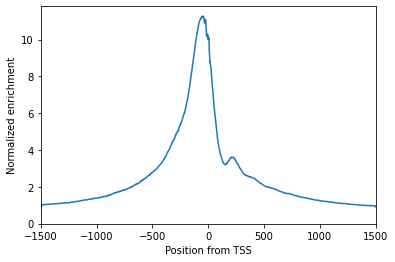

2021-06-03 18:01:16,872 cisTopic     INFO     Returning normalized sample TSS enrichment data


In [46]:
output = profile_tss(fragments = fragments_dict['HYA__combined__20210323_cortex_phu_dv_etssb_1.MERGED'],
                annotation = annot,
                valid_bc = None,
                plot = True,
                plot_data = None,
                flank_window = 1500,
                tss_window = 50,
                minimum_signal_window = 100,
                rolling_window = 10,
                min_norm = 0.2,
                return_TSS_enrichment_per_barcode = False,
                return_TSS_coverage_matrix_per_barcode = False,
                return_plot_data = True)

In [62]:
output['TSS_plot_data']

,Position,TSS_enrichment
0,-1501,0.525492
1,-1500,0.754025
2,-1499,0.833768
3,-1498,0.873037
4,-1497,0.900761
...,...,...
2996,1495,0.962345
2997,1496,0.965611
2998,1497,0.961091
2999,1498,0.960604


In [48]:
Audio(sound_file, autoplay=True)

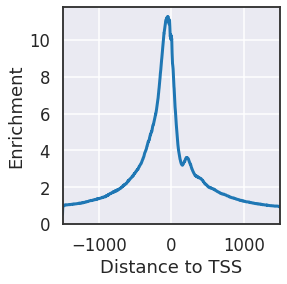

In [71]:
plt.close()
import seaborn as sns
style = 'darkgrid'
context = 'talk'
linewidth = 3

sns.set_style(style, {'axes.linewidth': 1, 'axes.edgecolor':'.20'})
sns.set_context(context)
color=sns.color_palette('Blues')[5]

sample = 'merged'
category = 'profile_tss'
xvar = 'Position'
yvar = 'TSS_enrichment'

ax = sns.lineplot(data=output['TSS_plot_data'], x='Position', y='TSS_enrichment', palette='viridis', linewidth=linewidth)
ax.set(xscale='linear')
ax.set(yscale='linear')
ax.set(xlim=[-1500, 1500])
ax.set_aspect('equal', adjustable='box')
ax.set_aspect(1./ax.get_data_ratio())

ax.set_xlabel('Distance to TSS')
ax.set_ylabel('Enrichment')

fig = plt.gcf()
fig.savefig('plts_pub/tss_enrichment.svg', dpi=100)
fig.savefig('plts_pub/tss_enrichment.tiff', dpi=100)
plt.show()

# Save metadata
Save cistopic's calculated metadata

In [ ]:
cistopic_out = wdir  + 'cistopic_out/'
if not os.path.exists(cistopic_out):
    os.makedirs(cistopic_out)

In [ ]:
cistopic_out = cistopic_out + 'quality+control/'
if not os.path.exists(cistopic_out):
    os.makedirs(cistopic_out)

In [ ]:
with open(cistopic_out + 'metadata_bc_mergedfrags.pkl', 'wb') as f:
  pickle.dump(metadata_bc_dict, f, protocol=4)

with open(cistopic_out + 'profile_data_dict_mergedfrags.pkl', 'wb') as f:
  pickle.dump(profile_data_dict, f, protocol=4)